In [1]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups 
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances
import pandas as pd
import numpy as np
import nltk
import re
#!pip install ntlk

In [2]:
with open('movie_summaries_bottom_250.txt', 'r') as myfile:
    summary=myfile.readlines()
with open('movie_titles_bottom_250.txt', 'r') as myfile:
    title= myfile.readlines()
title = [x.strip() for x in title] 
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
additional = ['\'s', 'one','two']
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(additional)

### Data Pre Processing

In [3]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [4]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [5]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [6]:
from gensim import corpora, models, similarities 

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in summary]
#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]
#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

c:\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Wall time: 448 ms
Wall time: 568 ms
Wall time: 53.1 ms


In [7]:
tokenized_text

[['unlock',
  'the',
  'never-before-seen',
  'secret',
  'world',
  'insid',
  'your',
  'smartphon',
  'within',
  'the',
  'messag',
  'app',
  'is',
  'a',
  'bustl',
  'citi',
  'where',
  'all',
  'your',
  'favorit',
  'emoji',
  'live',
  'hope',
  'to',
  'be',
  'select',
  'by',
  'the',
  'phone\\',
  "'s",
  'user',
  'this',
  'world',
  'each',
  'emoji',
  'has',
  'onli',
  'one',
  'facial',
  'express',
  'except',
  'for',
  'an',
  'exuber',
  'emoji',
  'who',
  'was',
  'born',
  'without',
  'a',
  'filter',
  'and',
  'is',
  'burst',
  'with',
  'multipl',
  'express',
  'to',
  'becom',
  'normal',
  'like',
  'the',
  'other',
  'emoji',
  'enlist',
  'the',
  'help',
  'of',
  'his',
  'handi',
  'best',
  'friend',
  'and',
  'the',
  'notori',
  'code',
  'breaker',
  'emoji',
  'they',
  'embark',
  'on',
  'an',
  'epic',
  'app-ventur',
  'through',
  'the',
  'app',
  'on',
  'the',
  'phone',
  'each',
  'it',
  'own',
  'wild',
  'and',
  'fun',
  '

In [68]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [69]:
num_topics =5
%time lda = models.LdaModel(corpus, num_topics, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

Wall time: 30.7 s


5

In [71]:
for i in range(0, 5):
    temp = lda.show_topic(i, 10)
    terms = []
    for term in temp:
        terms.append(term)
        
    print ("Top 10 terms for topic #" + str(i) + ": "+ ", ".join([i[0] for i in terms]))

Top 10 terms for topic #0: friend, girl, world, tri, becom, life, take, end, must, meet
Top 10 terms for topic #1: year, young, babi, world, take, captur, man, secret, kill, escap
Top 10 terms for topic #2: famili, find, kill, evil, world, get, shark, friend, father, young
Top 10 terms for topic #3: get, find, girl, want, time, make, back, live, group, friend
Top 10 terms for topic #4: evil, gang, friend, find, magic, power, time, treasur, becom, save


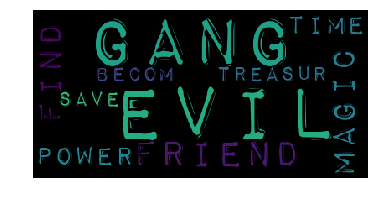

In [72]:
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 15)

## word clouds
from os import path
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def terms_to_wordcounts(terms, multiplier=1000):
    return  " ".join([" ".join(int(multiplier*i[1]) * [i[0]]) for i in terms])

wordcloud = WordCloud(font_path="impact-label\dahot2.Impact Label Reversed.ttf", background_color="black").generate(str (terms_to_wordcounts(terms)))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [79]:
!pip install ImageFont
n_topics =5

  Could not find a version that satisfies the requirement ImageFont (from versions: )
No matching distribution found for ImageFont


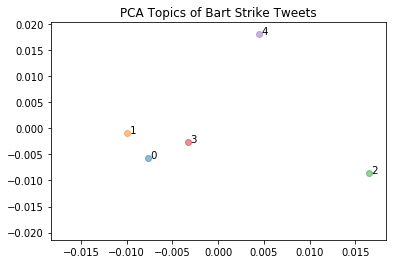

In [80]:
## topic-words vectors: topics vs. words
from sklearn.feature_extraction import DictVectorizer

def topics_to_vectorspace(n_topics, n_words=100):
    rows = []
    for i in range(n_topics):
        temp = lda.show_topic(i, n_words)
        row = dict(((i[0],i[1]) for i in temp))
        rows.append(row)

    return rows    

vec = DictVectorizer()

X = vec.fit_transform(topics_to_vectorspace(n_topics))
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_pca = pca.fit(X.toarray()).transform(X.toarray())

plt.figure()
for i in range(X_pca.shape[0]):
    plt.scatter(X_pca[i, 0], X_pca[i, 1], alpha=.5)
    plt.text(X_pca[i, 0], X_pca[i, 1], s=' ' + str(i))    

plt.title('PCA Topics of Bart Strike Tweets')
plt.show()
    

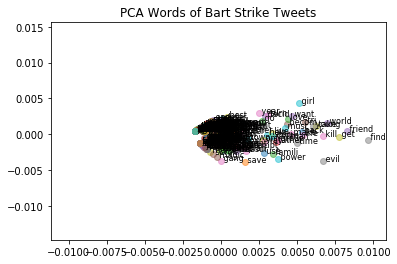

In [81]:
X_pca = pca.fit(X.T.toarray()).transform(X.T.toarray())

plt.figure()
for i, n in enumerate(vec.get_feature_names()):
    plt.scatter(X_pca[i, 0], X_pca[i, 1], alpha=.5)
    plt.text(X_pca[i, 0], X_pca[i, 1], s=' ' + n, fontsize=8)
    
plt.title('PCA Words of Bart Strike Tweets')

plt.show()

c:\anaconda3\lib\site-packages\ipykernel_launcher.py:16: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  app.launch_new_instance()


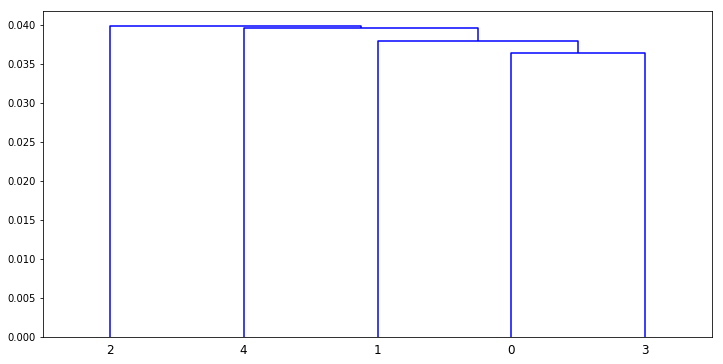

In [82]:
## hierarchical clustering
from scipy.cluster.hierarchy import linkage, dendrogram

plt.figure(figsize=(12,6))
R = dendrogram(linkage(X_pca))
plt.savefig("dendro")

plt.close()

## correlation matrix
from scipy.spatial.distance import pdist, squareform

cor = squareform(pdist(X.toarray(), metric="euclidean"))

plt.figure(figsize=(12,6))
R = dendrogram(linkage(cor))
plt.show()

c:\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:861: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
c:\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):


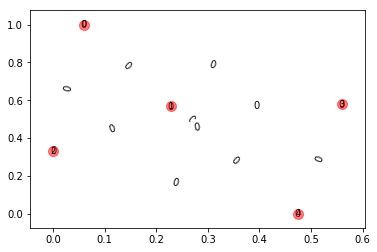

In [84]:
## network
import networkx as nx

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

pca_norm = make_pipeline(PCA(n_components=20), Normalizer(copy=False))

X_pca_norm = pca_norm.fit(X.toarray()).transform(X.toarray())

cor = squareform(pdist(X_pca_norm, metric="euclidean"))

G = nx.Graph()

for i in range(cor.shape[0]):
    for j in range(cor.shape[1]):
        if i == j:
            G.add_edge(i, j, {"weight":0})
        else:
            G.add_edge(i, j, {"weight":1.0/cor[i,j]})

edges = [(i, j) for i, j, w in G.edges(data=True) if w['weight'] > .8]
edge_weight=dict([((u,v,),int(d['weight'])) for u,v,d in G.edges(data=True)])

#pos = nx.graphviz_layout(G, prog="twopi") # twopi, neato, circo
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=100, alpha=.5)
nx.draw_networkx_edges(G, pos, edgelist=edges, width=1)
nx.draw_networkx_edge_labels(G, pos ,edge_labels=edge_weight)
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

plt.show()


In [85]:
fell_whitehead_path = nx.shortest_path(G, source="Margaret Fell", target="George Whitehead")

print("Shortest path between Fell and Whitehead:", fell_whitehead_path)

Network density: 1.5


In [87]:
G.edge

{0: {0: {'weight': 0},
  1: {'weight': 0.64235063413403037},
  2: {'weight': 0.62314646817640307},
  3: {'weight': 0.65662228845082826},
  4: {'weight': 0.62023374113025698}},
 1: {0: {'weight': 0.64235063413403037},
  1: {'weight': 0},
  2: {'weight': 0.61840387815874254},
  3: {'weight': 0.64086493098408692},
  4: {'weight': 0.63001795127618221}},
 2: {0: {'weight': 0.62314646817640307},
  1: {'weight': 0.61840387815874254},
  2: {'weight': 0},
  3: {'weight': 0.63288350903683077},
  4: {'weight': 0.63604892158758475}},
 3: {0: {'weight': 0.65662228845082826},
  1: {'weight': 0.64086493098408692},
  2: {'weight': 0.63288350903683077},
  3: {'weight': 0},
  4: {'weight': 0.62912159190614703}},
 4: {0: {'weight': 0.62023374113025698},
  1: {'weight': 0.63001795127618221},
  2: {'weight': 0.63604892158758475},
  3: {'weight': 0.62912159190614703},
  4: {'weight': 0}}}

In [ ]:
#https://gist.github.com/tokestermw/3588e6fbbb2f03f89798

In [78]:
import lda
from sklearn.feature_extraction.text import CountVectorizer

n_topics = 20 # number of topics
n_iter = 500 # number of iterations

# vectorizer: ignore English stopwords & words that occur less than 5 times
cvectorizer = CountVectorizer(min_df=5, stop_words='english')
cvz = cvectorizer.fit_transform(news)

# train an LDA model
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
X_topics = lda_model.fit_transform(cvz)

twisted 17.9.0 has requirement Automat>=0.3.0, but you'll have automat 0.0.0 which is incompatible.


### Reducing 2-D with t-SNE

In [61]:
X_topics = lda_model.fit_transform(cvz)
from sklearn.manifold import TSNE

# a t-SNE model
# angle value close to 1 means sacrificing accuracy for speed
# pca initializtion usually leads to better results 
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

# 20-D -> 2-D
tsne_lda = tsne_model.fit_transform(X_topics)

NameError: name 'X_topics' is not defined